In [155]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from itertools import product

#### Summary

This project deals with data analysis on the dataset on loan applications, stored in `data.csv` <br>
The goal is to predict `TARGET` variable (TARGET = 1 if loan was not paid in time), based on the loan applicants' attributes: credit history, gender, age, etc.

Before performing data analysis on the given data set, we first examine the dataset structure:

In [156]:
df = pd.read_csv("data.csv")
max_age = df['NUM_AGE'].max()
min_age = df['NUM_AGE'].min()

mode = df['NUM_AGE'].mode()
mean = df['NUM_AGE'].mean()
mean_in_cz = 42.7 # source: https://scitani.gov.cz/vysledky

print(f'Maximum age of loan applicant: {max_age}')
print(f'Mode age of loan applicant: {mode.values[0]}')
print(f'Mean age of loan applicant: {mean}, {round(mean_in_cz-mean)} years less than the average age of population in the Czech Republic.')
print("")
print("Dataset info:")
df.info()

Maximum age of loan applicant: 84
Mode age of loan applicant: 20
Mean age of loan applicant: 30.5874, 12 years less than the average age of population in the Czech Republic.

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CODE_ZIP                 5000 non-null   int64  
 1   AMT_NET_INCOME           5000 non-null   int64  
 2   AMT_REQUESTED_TICKET     5000 non-null   float64
 3   TEXT_BANK                4969 non-null   object 
 4   NUM_AGE                  5000 non-null   int64  
 5   TEXT_GENDER              5000 non-null   object 
 6   NFLAG_MOBILEDEVICE       5000 non-null   int64  
 7   CODE_IP_1                5000 non-null   int64  
 8   NUM_LEVEN_EMAIL          5000 non-null   int64  
 9   NFLAG_EMAIL_NUMERAL      5000 non-null   int64  
 10  CNT_REJECTED             5000 non-null   int64  
 1

#### Normalization

The above dataset summary displays, which column corresponds to which type and how many non-null values there are. Before processing, we need to normalize data - in this case, fill out the missing data.
`TEXT_BANK` column has 31 blank values. We can either delete the corresponding records, or assume they correspond to "Other" banks or some "Anonymous" bank.

In [157]:
df['TEXT_BANK'] = df['TEXT_BANK'].fillna('Anonymous Bank')

#### Age groups
Based on the data provided, the majority of loan applicants, younger than 49, are men.

In [158]:
age_bins = [18, 28, 38, 48, 58, 68, 78, 88]
age_labels = ['18-28', '29-38', '39-48', '49-58', '59-68', '69-78', '79-88']

age_gender_pivot = df
age_gender_pivot['AGE_RANGE'] = pd.cut(age_gender_pivot["NUM_AGE"], bins=age_bins, labels=age_labels, right=False)
age_gender_pivot = age_gender_pivot.pivot_table(index='AGE_RANGE', columns=['TEXT_GENDER'], aggfunc='size', fill_value=0, observed=False)

display(age_gender_pivot)

TEXT_GENDER,Muž,Žena
AGE_RANGE,,
18-28,1529,1014
29-38,847,523
39-48,340,332
49-58,125,135
59-68,44,61
69-78,12,35
79-88,0,3


#### Target rate by bank

The highest target rate is in Anonymous Bank, NP Paribas Personal Finance SA and Raiffeisenbank.

In [159]:
bank_pivot = df.pivot_table(index='TEXT_BANK', columns='TARGET', aggfunc='size', fill_value=0)
bank_pivot['target_rate'] = bank_pivot[1]/(bank_pivot[0] + bank_pivot[1])*100
print(bank_pivot.sort_values(by='target_rate', ascending=False))

TARGET                                               0    1  target_rate
TEXT_BANK                                                               
Anonymous Bank                                      23    8    25.806452
BNP Paribas Personal Finance SA, odštěpný závod      7    2    22.222222
Raiffeisenbank a.s.                                238   44    15.602837
mBank S.A., organizační složka                     124   17    12.056738
Česká spořitelna, a.s.                            1112  142    11.323764
UniCredit Bank Czech Republic and Slovakia, a.s.   159   19    10.674157
Air Bank a.s.                                      606   71    10.487445
Fio banka, a.s.                                    217   22     9.205021
Komerční banka, a.s.                               457   42     8.416834
Equa bank a.s.                                     320   29     8.309456
MONETA Money Bank, a.s.                            655   57     8.005618
Československá obchodní banka, a.s.                

#### Age categories by target rate

In [160]:
grouped_age_target = df.groupby(['NUM_AGE', 'TARGET']).size().reset_index(name='COUNT')

age_trends = grouped_age_target.groupby(['NUM_AGE', 'TARGET'])['COUNT'].sum().unstack(fill_value=0).reset_index()
age_trends['TARGET_RATE'] = age_trends[1] / (age_trends[0] + age_trends[1])

After grouping all records by age and calculating the average target rate for each single age from 18 to 84, we can see that the target rate can vary. 

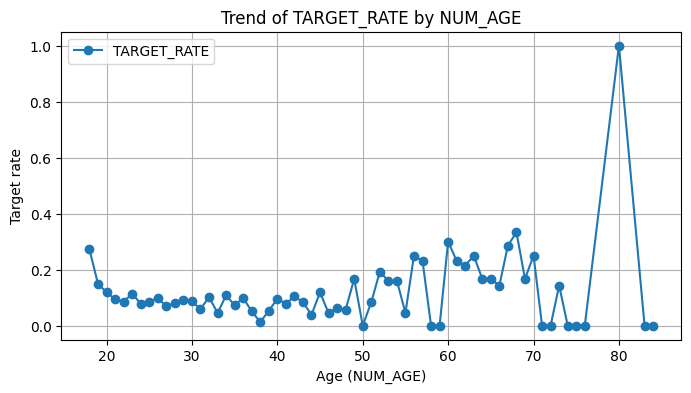

In [161]:
plt.figure(figsize=(8, 4))
plt.plot(age_trends['NUM_AGE'], age_trends['TARGET_RATE'], label='TARGET_RATE', marker='o')
plt.title('Trend of TARGET_RATE by NUM_AGE')
plt.xlabel('Age (NUM_AGE)')
plt.ylabel('Target rate')
plt.legend()
plt.grid(True)
plt.show()

The mere graph of TARGET_RATE by NUM_AGE is not enough to determine custom age categories. K-means is a good method to detect trends in data and "draw the border" between multiple clusters. I have defined the below functions to experiment with different number of clusters and visualize the resulting clusters.

`age_clusters` function will prepare `age_labels` and `age_bins` -- these are the margins of the age categories, used by `target_rate_by_age_group` function to generate a dataframe with the new `AGE_RANGE` column.

In [162]:
def age_clusters(age_stats):
    age_labels = []
    for i, bin in age_stats.iterrows():
        label = f'{bin['min']} - {bin['max']}'
        age_labels.append(label)

    age_bins = []
    age_bins.append(int(age_stats['min'][0]))
    age_bins.extend(age_stats['max'].to_list())
    return age_bins, age_labels

def target_rate_by_age_group(age_bins, age_labels):
    age_pivot = df
    age_pivot['AGE_RANGE'] = pd.cut(age_pivot["NUM_AGE"], bins=age_bins, labels=age_labels, right=False)
    age_pivot = age_pivot.pivot_table(index='AGE_RANGE', columns=['TARGET'], aggfunc='size', fill_value=0, observed=False)
    age_pivot['TARGET_RATE'] = age_pivot[1] / (age_pivot[0] + age_pivot[1]) * 100
    return age_pivot

In [163]:
def scatter_plot_by_age_group(age_trends):
    cluster_0 = age_trends[age_trends['Age_Group'] == 0]
    cluster_1 = age_trends[age_trends['Age_Group'] == 1]
    cluster_2 = age_trends[age_trends['Age_Group'] == 2]
    cluster_3 = age_trends[age_trends['Age_Group'] == 3]
    cluster_4 = age_trends[age_trends['Age_Group'] == 4]
    cluster_5 = age_trends[age_trends['Age_Group'] == 5]

    plt.scatter(cluster_0['TARGET_RATE'], cluster_0['NUM_AGE'], label='Cluster 0')
    plt.scatter(cluster_1['TARGET_RATE'], cluster_1['NUM_AGE'], label='Cluster 1')
    plt.scatter(cluster_2['TARGET_RATE'], cluster_2['NUM_AGE'], label='Cluster 2')
    plt.scatter(cluster_3['TARGET_RATE'], cluster_3['NUM_AGE'], label='Cluster 3')
    plt.scatter(cluster_4['TARGET_RATE'], cluster_4['NUM_AGE'], label='Cluster 4')
    plt.scatter(cluster_5['TARGET_RATE'], cluster_5['NUM_AGE'], label='Cluster 5')
    plt.show()

5 was the best number of clusters, as there was still some variance in target rate by age group.

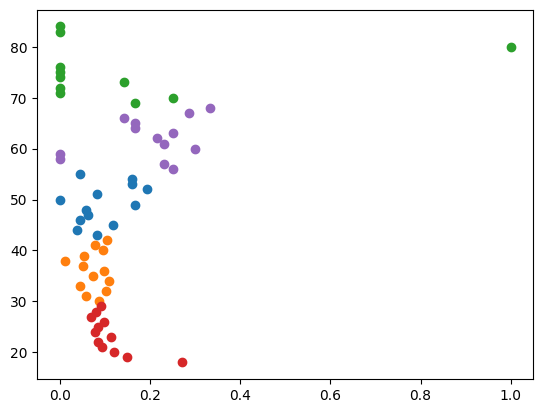

In [164]:
age_trends['Age_Group'] = KMeans(n_clusters=5, random_state=0).fit_predict(age_trends[['NUM_AGE']])
age_stats = age_trends.groupby('Age_Group')['NUM_AGE'].agg(['min', 'max']).reset_index()
age_stats = age_stats.sort_values('min').reset_index()

scatter_plot_by_age_group(age_trends=age_trends)


The final age categories and the aggregated target rate are displayed in the below table. 

In [165]:
age_bins, age_labels = age_clusters(age_stats)
age_table = target_rate_by_age_group(age_bins, age_labels)

display(age_table)

TARGET,0,1,TARGET_RATE
AGE_RANGE,,,
18 - 29,2453,301,10.929557
30 - 42,1354,111,7.576792
43 - 55,520,51,8.931699
56 - 68,133,27,16.875000
69 - 84,42,7,14.285714


#### Target rate by age group and bank

Next, we will analyze target rate for each age group in each bank.

In [166]:
unique_ages = range(min_age, max_age+1)
unique_banks = df['TEXT_BANK'].unique()
unique_targets = df['TARGET'].unique()

grouped_age_target_bank = df.groupby(['NUM_AGE', 'TEXT_BANK', 'TARGET']).size().reset_index(name='COUNT')

all_combinations = pd.DataFrame(
    list(product(unique_ages, unique_banks, unique_targets)),
    columns=['NUM_AGE', 'TEXT_BANK', 'TARGET']
)

grouped_age_target_bank_output = all_combinations.merge(grouped_age_target_bank, on=['NUM_AGE', 'TEXT_BANK', 'TARGET'], how='left').fillna(0)

# Ensure COUNT is an integer
grouped_age_target_bank_output['COUNT'] = grouped_age_target_bank_output['COUNT'].astype(int)

non_zero_banks = grouped_age_target_bank_output.groupby(['NUM_AGE', 'TEXT_BANK'])['COUNT'].transform('sum') > 0
filtered_data = grouped_age_target_bank_output[non_zero_banks]

target_rate_data = filtered_data.pivot_table(
    index=['NUM_AGE', 'TEXT_BANK'],
    columns='TARGET',
    values='COUNT',
    aggfunc='sum',
    fill_value=0
).reset_index()

target_rate_data.columns.name = None
target_rate_data = target_rate_data.rename(columns={0: 'COUNT_0', 1: 'COUNT_1'})

target_rate_data['AGE_CATEGORY'] = pd.cut(target_rate_data['NUM_AGE'], bins=age_bins, labels=age_labels, right=False)

result = target_rate_data.groupby(['TEXT_BANK', 'AGE_CATEGORY'], observed=False).agg(
    TOTAL_COUNT_0=('COUNT_0', 'sum'),
    TOTAL_COUNT_1=('COUNT_1', 'sum')
).reset_index()

result['TARGET_RATE'] = result['TOTAL_COUNT_1'] / ( result['TOTAL_COUNT_1'] +  result['TOTAL_COUNT_0']) * 100
result = result.drop(columns=['TOTAL_COUNT_1', 'TOTAL_COUNT_0'])


The results are possible to graph using histrogram or plot, such as below. Because there are too much data to fit on one plot, it is possible to determine which banks we want to showcase -- I have chosen the most popular ones. If there is missing data (no loan apllicants for specific age and bank group), the line does not go to TARGET_RATE=0, but dissapears from the plot.

On the plot, we can also see a black line, corresponding to average for specific age group. Based on out needs we can extract the following information:

- except for the oldest age group, taret rate is consistently higher than the average for Raiffeisenbank and lower for Československá obchodní banka
- 18-29 age group pays off their loans the most at mBank, the least at UniCredit

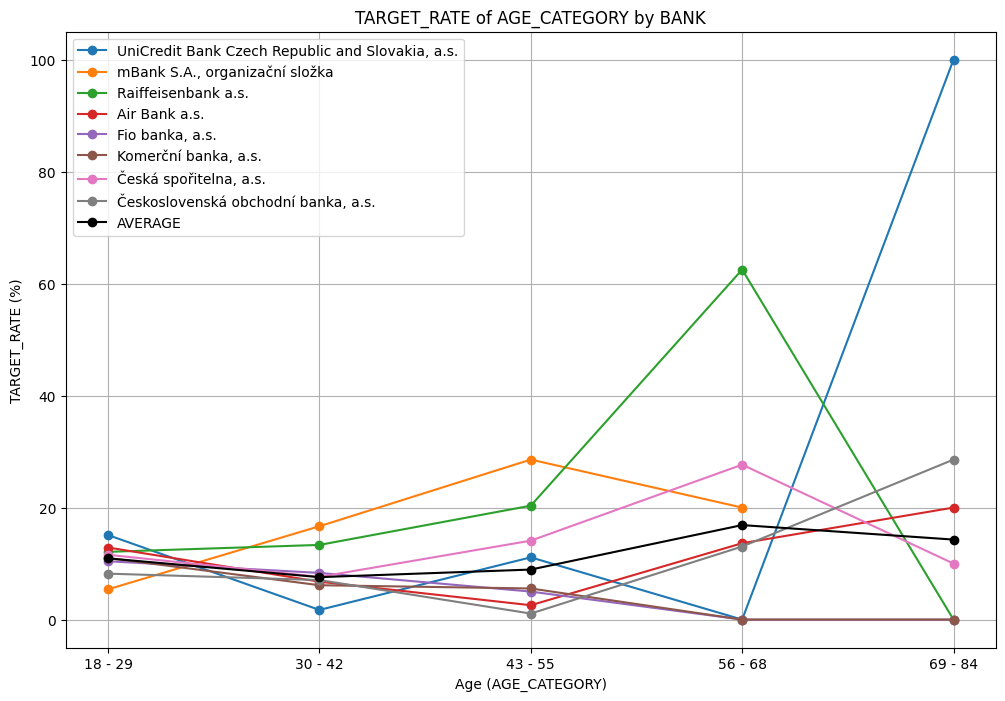

In [167]:
banks_of_interest = ["UniCredit Bank Czech Republic and Slovakia, a.s.",
                     "mBank S.A., organizační složka",
                     "Raiffeisenbank a.s.",
                     "Air Bank a.s.",
                     "Fio banka, a.s.",
                     "Komerční banka, a.s.",
                     "Česká spořitelna, a.s.",
                     "Československá obchodní banka, a.s."]

plt.figure(figsize=(12, 8))

for i in banks_of_interest:
    line_result = result[result['TEXT_BANK'] == i]
    plt.plot(line_result['AGE_CATEGORY'], line_result['TARGET_RATE'], label=str(i), marker='o')
plt.plot(line_result['AGE_CATEGORY'], age_table['TARGET_RATE'], label="AVERAGE", marker='o', color='black')
plt.title('TARGET_RATE of AGE_CATEGORY by BANK')
plt.xlabel('Age (AGE_CATEGORY)')
plt.ylabel('TARGET_RATE (%)')
plt.legend()
plt.grid(True)
plt.show()

#### Rejection criteria

To reject a loan to the people that will likely not pay it off, we need to define features of the clients that have not paid the loans in the past.

We can start with simple corellation between each numerical variable and TARGET. Based on the results below, we cannot see a high correlation.

In [168]:
correlations = df.corrwith(df['TARGET'], method='pearson', numeric_only=True)
print(correlations.sort_values(ascending=False))

TARGET                     1.000000
AMT_REQUESTED_TICKET       0.097672
NFLAG_EMAIL_NUMERAL        0.063183
NFLAG_MOBILEDEVICE         0.049548
CNT_REJECTED               0.021016
AMT_NET_INCOME            -0.005383
NUM_AGE                   -0.016993
CODE_ZIP                  -0.051094
CODE_IP_1                 -0.060223
NUM_LEVEN_EMAIL           -0.061472
NUM_DAYS_CREDIT_HISTORY   -0.084674
dtype: float64


Let us visualize two attributes: with the highest positive and highest negative correlation. We can see that the plots do not display a strong trend.

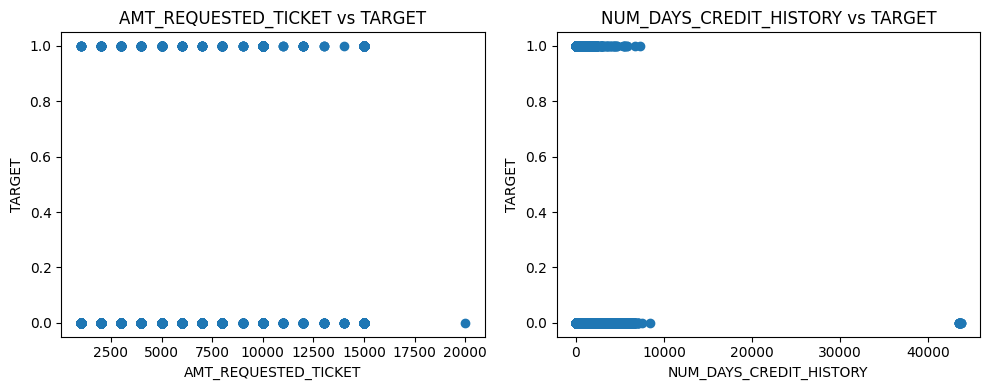

In [169]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

axes[0].scatter(df['AMT_REQUESTED_TICKET'], df['TARGET'])
axes[0].set_title('AMT_REQUESTED_TICKET vs TARGET')
axes[0].set_xlabel('AMT_REQUESTED_TICKET')
axes[0].set_ylabel('TARGET')

axes[1].scatter(df['NUM_DAYS_CREDIT_HISTORY'], df['TARGET'])
axes[1].set_title('NUM_DAYS_CREDIT_HISTORY vs TARGET')
axes[1].set_xlabel('NUM_DAYS_CREDIT_HISTORY')
axes[1].set_ylabel('TARGET')

plt.tight_layout()
plt.show()

#### Model 

Instead of correlation, I want to try capture some non-linear relationships between variables: feature importance. For that, I need to train a model, because feature importance displays how much each feature contributes to a model's predictions.

Logistic regression is a widely used algorithm for binary classification problems, making it great for the task of predicting a binary target variable (`TARGET`, such as 0 or 1) in this dataset. Besides the feature importance, it can mainly be used for prediction of `TARGET` variable based on the other input variables.

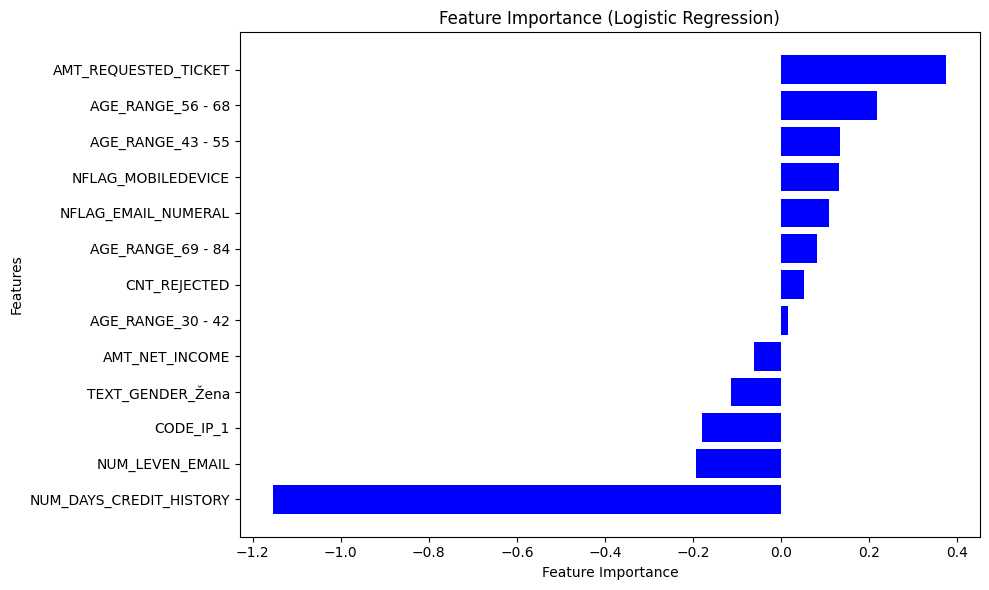

In [170]:
regression = df
X = regression.drop(columns=['TARGET', 'TEXT_BANK', 'NUM_AGE', 'CODE_ZIP'])
y = regression['TARGET']

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.coef_[0]
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='blue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (Logistic Regression)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Set with the highest TARGET_RATE

To create a set with the high-risk individuals, we can filter the existing set with the detected features. Function `count_set_target_rate` will then help compare the average target rate in the default set and the filtered one.

In [171]:
def count_set_target_rate(dataframe):
    total_target_rate = dataframe['TARGET'].sum() / len(dataframe)
    return total_target_rate

To select the set with highest possible target rate, I filter out the high-risk age categories, or in case of continuous numerical value, specify a threshold.

In [172]:
amt_requested_ticket_threshold = df['AMT_REQUESTED_TICKET'].quantile(0.50)
days_credit_history_threshold = df['NUM_DAYS_CREDIT_HISTORY'].quantile(0.50)

filtered_df = df[
    (df['AMT_REQUESTED_TICKET'] >= amt_requested_ticket_threshold) &  # High ticket amount
    (df['AGE_RANGE'].isin(['56 - 68', '43 - 55'])) &  # Favorable age ranges
    (df['NFLAG_MOBILEDEVICE'] == 1) &  # Mobile device flag is 1
    (df['NUM_DAYS_CREDIT_HISTORY'] <= days_credit_history_threshold) &  # Low days credit history
    (df['NUM_LEVEN_EMAIL'] <= df['NUM_LEVEN_EMAIL'].median())  # Moderate email scores
]

res_default = count_set_target_rate(df)
res = count_set_target_rate(filtered_df)

print(f'New set of {len(filtered_df)} rows has average target rate of {round(res*100)}%, comparing to the default target rate of {round(res_default*100)}%.')


New set of 32 rows has average target rate of 69%, comparing to the default target rate of 10%.


However, in case we need a certain percentage of the input dataset, for example 200 out of 5000 records, the selection process would be:
- Assign weights based on feature importance
- Create feature-based score
- Select the top 200 rows based on the score


In [173]:
weights = {
    'AMT_REQUESTED_TICKET': 0.375854,
    'AGE_RANGE_56 - 68': 0.218514,
    'AGE_RANGE_43 - 55': 0.134054,
    'NFLAG_MOBILEDEVICE': 0.130912,
    'NFLAG_EMAIL_NUMERAL': 0.108124,
    'NUM_DAYS_CREDIT_HISTORY': -1.151213,
}

df['SCORE'] = (
    weights['AMT_REQUESTED_TICKET'] * df['AMT_REQUESTED_TICKET'] +
    weights['AGE_RANGE_56 - 68'] * (df['AGE_RANGE'] == '56 - 68').astype(int) +
    weights['AGE_RANGE_43 - 55'] * (df['AGE_RANGE'] == '43 - 55').astype(int) +
    weights['NFLAG_MOBILEDEVICE'] * df['NFLAG_MOBILEDEVICE'] +
    weights['NFLAG_EMAIL_NUMERAL'] * df['NFLAG_EMAIL_NUMERAL'] +
    weights['NUM_DAYS_CREDIT_HISTORY'] * df['NUM_DAYS_CREDIT_HISTORY']
)

filtered_df = df.nlargest(200, 'SCORE')
res = count_set_target_rate(filtered_df)

print(f'New set of {len(filtered_df)} rows has average target rate of {round(res*100)}%, comparing to the default target rate of {round(res_default*100)}%.')


New set of 200 rows has average target rate of 33%, comparing to the default target rate of 10%.


#### Data enrichment

I will enrich the dataset with the names of districts, that correspond to post index (PSC).

The input, `psc.csv` is taken from https://www.ceskaposta.cz/ke-stazeni/zakaznicke-vystupy <br>
Output will be written to `enriched_data.csv`

In [174]:
enriched_df = df
enriched_df['GENDER'] = enriched_df['TEXT_GENDER'].map({'Muž': 0, 'Žena': 1})

post_codes = pd.read_csv("pcs.csv", encoding='iso8859-2')
post_codes.rename(columns={'PSC': 'CODE_ZIP'}, inplace=True)

model_df = enriched_df.merge(post_codes[['CODE_ZIP', 'NAZOKRESU']], on='CODE_ZIP', how='left')

enriched_df.to_csv("enriched_data.csv")